## PYTORCH 를 이용한 mnist FC classifier 

fully-connected layer 만을 이용해서 MNIST 데이터를 분류해보도록 하겠습니다. 
지금까지 numpy 를 이용해서 저희 밑바닥부터 모든 작업들을 진행했다면, 이제는 pytorch framework 이 제공하는 편리한 기능들을 이용하도록 하겠습니다. 얼마나 편리하게 만들어져 있는지 직접 경험해 보도록 합시다.



__( 나중에 여기에 이론 슬라이드를 첨부해 넣도록 하겠습니다.)__

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


GPU 가 존재한다면 GPU 의 강력함을 한번 느껴보도록 할까요. 먼저 CPU 로 한번 계산해보고 나중에 GPU 로 연산을 했을때 얼마나 빨라지는지 테스트 해보도록 하겠습니다.

In [3]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### MNIST Dataset 을 load 합니다. 

training dataset, test dataset 을 편리하게 loading 하게 만들어주는 메쏘드들이 이미 잘 구현이 되어 있습니다. 이 과정에서 다양한 normalize, data augmentation 등을 transforms 라는 녀석을 통해서 손쉽게 구현해 넣을 수 있습니다.


In [4]:
input_size = 28 * 28
output_size = 10    # 0~9 까지 총 10개로 분류되어야 하기 때문입니다. 


train_dataset = datasets.MNIST('./sample_data', train=True, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),   # transform 에 들어오는 image 는 항상 PIL type 이어야 합니다. 
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

test_dataset = datasets.MNIST('./sample_data', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))
                             ]))

train_loader = torch.utils.data.DataLoader( train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader( test_dataset, batch_size=1000, shuffle=True)


몇개의 training dataset 을 한번 시각화해보도록 하겠습니다. 

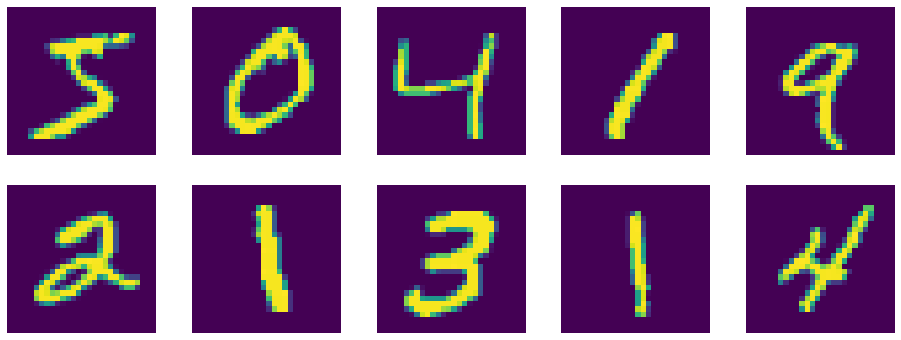

In [5]:
plt.figure(figsize=(16,6))

for i in range(10):
    plt.subplot(2, 5, i+1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')

## 이제 Fully Connected Layer 모델을 만들어 봅시다.

(cf. Multi-class classifier 를 만들때 혼동되는 부분중에 하나가 왜 마지막 layer 에 softmax 를 넣지 않지요? 라고 질문주시는 분들이 있는데요. 우리가 아래에서 사용할 loss 함수가 CrossEntropyLoss() 를 사용하기 때문입니다. Network 의 끝단에 softmax( nn.LogSoftmax() 를 사용합니다. ) 를 사용할 경우에는 loss 함수계산 역시 NLLLoss 를 사용해야 합니다. 자세한 내용은 http://www.gisdeveloper.co.kr/?p=8668 를 참고하세요. )

In [6]:
class fc_layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(fc_layer, self).__init__() 
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
        )
        
    def forward(self, x):
        x = x.view(-1, self.input_size)  # 28*28 2D array 를 784 1D array 로 flatten 합니다.
        return self.network(x)

In [7]:
epoch = 5
learning_rate = 0.001

n_hidden = 7   # hidden unit 을 5개로 정의합니다.  

# 우리가 만든 model instance 를 initiate 합니다. 이제 net 라는 model 이 memory 에 존재하기 시작합니다. 
# 우리가 학습을 시킬 parameter 들은 이 안에 들어있지요. 
net = fc_layer( input_size, n_hidden, output_size)
net.to(device)  # torch.device() 에서 setup 한 device 의 memory 로 모델을 load 합니다. 

# loss 함수를 정의합니다. 
criterion = nn.CrossEntropyLoss()

# optimizer 를 정의합니다. Adam 을 사용해보도록 합시다. 
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# 질문, net.parameters() 에 존재하는 trainable parameter 의 숫자는 몇개일까요?

loss_trail = []

for epoch_idx in range(epoch):    # Epoch iterator
    batch_idx = 0
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print("epoch: %d, batch_idx: %d, loss: %f" % (epoch_idx, batch_idx, loss.item()))
            loss_trail.append(loss.item())
            
        batch_idx += 1
    
    


epoch: 0, batch_idx: 0, loss: 2.354641
epoch: 0, batch_idx: 100, loss: 1.843692
epoch: 0, batch_idx: 200, loss: 0.847650
epoch: 0, batch_idx: 300, loss: 0.551566
epoch: 0, batch_idx: 400, loss: 0.623731
epoch: 0, batch_idx: 500, loss: 0.372890
epoch: 0, batch_idx: 600, loss: 0.577731
epoch: 0, batch_idx: 700, loss: 0.405185
epoch: 0, batch_idx: 800, loss: 0.427895
epoch: 0, batch_idx: 900, loss: 0.301895
epoch: 1, batch_idx: 0, loss: 0.714052
epoch: 1, batch_idx: 100, loss: 0.453859
epoch: 1, batch_idx: 200, loss: 0.634167
epoch: 1, batch_idx: 300, loss: 0.326146
epoch: 1, batch_idx: 400, loss: 0.285441
epoch: 1, batch_idx: 500, loss: 0.243898
epoch: 1, batch_idx: 600, loss: 0.618391
epoch: 1, batch_idx: 700, loss: 0.441754
epoch: 1, batch_idx: 800, loss: 0.289687
epoch: 1, batch_idx: 900, loss: 0.394550
epoch: 2, batch_idx: 0, loss: 0.582844
epoch: 2, batch_idx: 100, loss: 0.453051
epoch: 2, batch_idx: 200, loss: 0.223236
epoch: 2, batch_idx: 300, loss: 0.283516
epoch: 2, batch_idx: 4

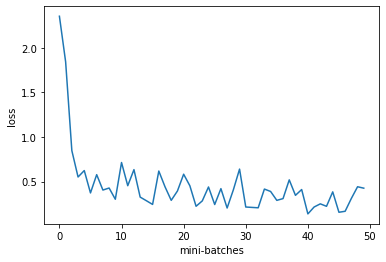

In [8]:
plt.plot(range(len(loss_trail)), loss_trail)
plt.ylabel('loss')
plt.xlabel('mini-batches')
plt.show()

테스트를 한번 해볼까요? 

In [9]:
correct = 0 

with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
    
        output = net(data)
        test_loss = criterion(output, label)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()

print("test accuracy %f" % (100. * correct / len(test_loader.dataset)))

test accuracy 91.160000


과제 .1   GPU 를 사용하도록 코드를 변경해봅시다.

과제. 2   epoch 과 hidden layer 의 neuron 갯수(n_hidden) 를 조정해서 test accuracy 가 어떻게 바뀌는지 테스트해봅시다.